In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
# Load the data from the CSV file
df = pd.read_csv('BTC-USD.csv')
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-05-22,8419.870117,8423.250000,8004.580078,8041.779785,8041.779785,5137010176
1,2018-05-23,8037.080078,8054.660156,7507.879883,7557.819824,7557.819824,6491120128
2,2018-05-24,7561.120117,7738.600098,7331.140137,7587.339844,7587.339844,6049220096
3,2018-05-25,7592.299805,7659.140137,7392.649902,7480.140137,7480.140137,4867829760
4,2018-05-26,7486.479980,7595.160156,7349.120117,7355.879883,7355.879883,4051539968


In [3]:
#Convert Date column into Datatime format
df['Date'] = pd.to_datetime(df.Date)

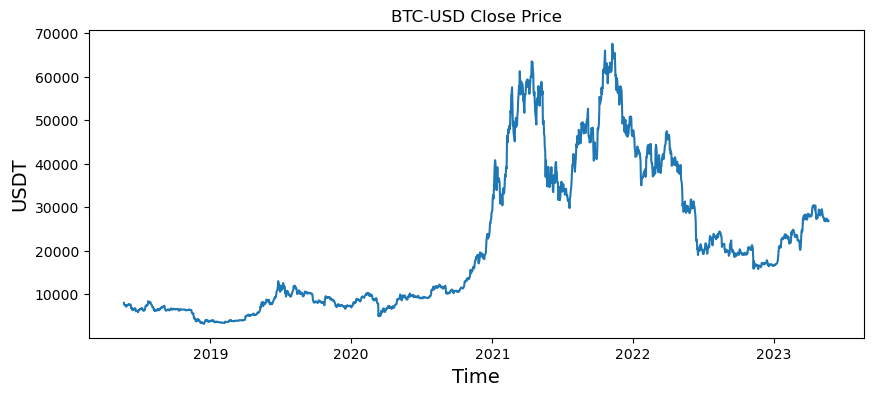

In [4]:
# Visualize the close price history
plt.figure(figsize=(10, 4))
plt.plot(df['Date'], df['Close'])
plt.title('BTC-USD Close Price')
plt.xlabel("Time", fontsize=14,)
plt.ylabel("USDT", fontsize=14)
plt.show()

In [5]:
df = df[['Date', 'Close']]

df.set_index('Date', inplace=True)

In [6]:
# Convert the data to a numpy array
data = df.values

In [7]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [8]:
# Define the number of time steps and features
num_time_steps = 70
num_features = 1

In [9]:
# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

In [10]:
# Define a function to create the input and output sequences for the model
def create_sequences(data, time_steps):
    X = []
    y = []
    for i in range(len(data) - time_steps - 10):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps:i + time_steps + 10, 0])
    return np.array(X), np.array(y)

In [11]:
# Create the training sequences
X_train, y_train = create_sequences(train_data, num_time_steps)

# Create the testing sequences
X_test, y_test = create_sequences(test_data, num_time_steps)

In [12]:
# Reshape the input sequences to match the expected shape of the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], num_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], num_features))

In [13]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.GRU(50, return_sequences=True, input_shape=(X_train.shape[1], num_features)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(50),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# print the summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 70, 50)            7950      
                                                                 
 dropout (Dropout)           (None, 70, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
Total params: 23,760
Trainable params: 23,760
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Train the model
history = model.fit(X_train, 
                    y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_test, y_test), 
                    verbose=1)

Epoch 1/50
44/44 [==============================] - 5s 17ms/step - loss: 0.0479 - val_loss: 0.0018
Epoch 2/50
44/44 [==============================] - 0s 8ms/step - loss: 0.0088 - val_loss: 7.1725e-04
Epoch 3/50
44/44 [==============================] - 0s 8ms/step - loss: 0.0070 - val_loss: 7.6308e-04
Epoch 4/50
44/44 [==============================] - 0s 8ms/step - loss: 0.0065 - val_loss: 6.6560e-04
Epoch 5/50
44/44 [==============================] - 0s 8ms/step - loss: 0.0061 - val_loss: 7.3253e-04
Epoch 6/50
44/44 [==============================] - 0s 8ms/step - loss: 0.0057 - val_loss: 0.0010
Epoch 7/50
44/44 [==============================] - 0s 8ms/step - loss: 0.0048 - val_loss: 6.8363e-04
Epoch 8/50
44/44 [==============================] - 0s 8ms/step - loss: 0.0051 - val_loss: 0.0014
Epoch 9/50
44/44 [==============================] - 0s 8ms/step - loss: 0.0046 - val_loss: 6.5135e-04
Epoch 10/50
44/44 [==============================] - 0s 8ms/step - loss: 0.0043 - val_loss: 6

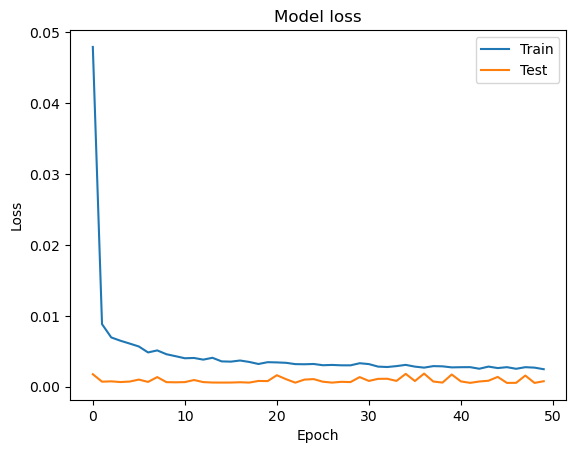

In [15]:
# Plot the training and validation loss over time
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [16]:
# Use the model to make predictions on the testing set
y_pred = model.predict(X_test)

# Rescale the predicted and actual values
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

9/9 [==============================] - 0s 3ms/step


In [17]:
# Reshape the predictions and actual values
y_pred = y_pred.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [18]:
# Inverse transform the rescaled values to their original scale
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

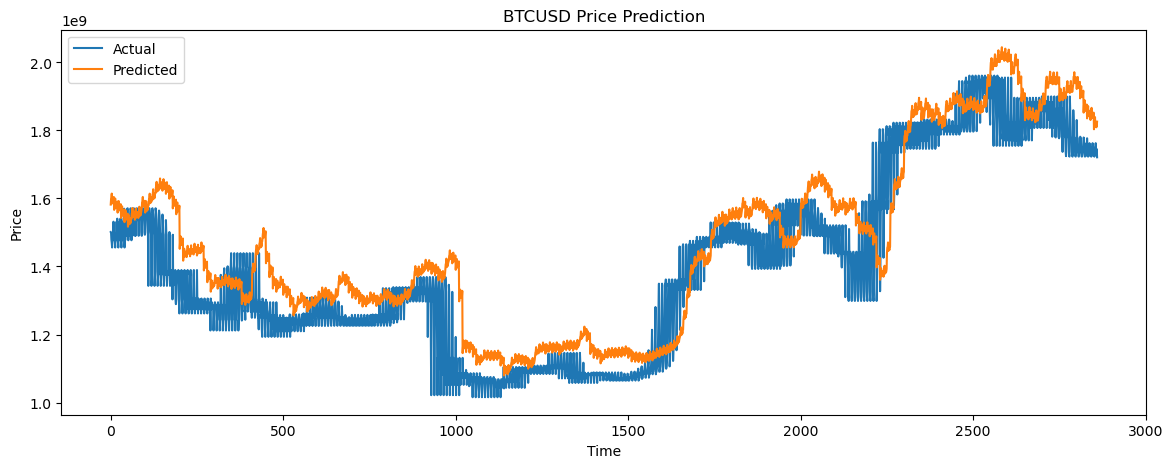

In [19]:
# Plot the predicted and actual BTCUSD prices
fig = plt.figure(figsize=(14,5))
plt.plot(y_test[:, 0], label='Actual')
plt.plot(y_pred[:, 0], label='Predicted')
plt.title('BTCUSD Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [20]:
# Make a prediction for the next 10 days

# Select the last 70 days of scaled data as input for prediction
last_70_days = scaled_data[-70:]

# Reshape the data to match the model's input shape
last_70_days = last_70_days.reshape((1, num_time_steps, num_features))

# Use the model to make a prediction based on the last 70 days of data
prediction = model.predict(last_70_days)

# Inverse transform the scaled prediction to get the actual BTC-USD prices
prediction = scaler.inverse_transform(prediction)

# print the next 10 days' BTCUSD price prediction
# print('Next 10 days\' BTCUSD price prediction:', prediction[0])


1/1 [==============================] - 0s 14ms/step


In [21]:
# Read the CSV file containing BTC price data
df = pd.read_csv('BTC-USD.csv')

# Determine the size of the training set (80% of the total data)
train_size = int(len(df) * 0.8)

# Extract the dates from the testing set
dates = df.loc[df.index >= train_size, 'Date']

# Get the last date in the testing set, which will be used as the current date for predictions
current_date = dates.iloc[-1]

# Generate a sequence of 10 future dates starting from the current date, with a frequency of 1 day
future_dates = pd.date_range(current_date, periods=10, freq='D')

# Iterate over each future date and its corresponding index
for i, date in enumerate(future_dates):
    # Access the prediction value for the current date and print it
    print(f"{date.date()} - BTCUSD price prediction: {prediction[0][i]:.2f}")

2023-05-22 - BTCUSD price prediction: 27657.89
2023-05-23 - BTCUSD price prediction: 27966.49
2023-05-24 - BTCUSD price prediction: 28000.53
2023-05-25 - BTCUSD price prediction: 28202.90
2023-05-26 - BTCUSD price prediction: 27742.30
2023-05-27 - BTCUSD price prediction: 27981.54
2023-05-28 - BTCUSD price prediction: 27917.48
2023-05-29 - BTCUSD price prediction: 27744.34
2023-05-30 - BTCUSD price prediction: 27850.79
2023-05-31 - BTCUSD price prediction: 28002.08
